# CS6476 - Object Detection Assignment

# AIM
The aim of this assignment is to implement single-stage detector - YoloV3 on PascalVOC2007 dataset.

## Learning Objectives
- Understanding YoloV3 architecture and its components - Backbone, Feature Pyramid Network (FPN) and Yolo heads (classification and regression).
- Developing basic understanding of post-processing concepts like Non-maxima suppression
- Developing basic understanding of loss formulation in object detection setup
- End-to-end training of object detection networks

## Grading Schema
The assignment will be graded out of 100.
- Yolo head (25)
- Yolo Forward Pass (10)
- Yolo losses (20)
- Non-maxima suppression (15)
- Training Yolo and reporting mean Average Precision (mAP) (30)

## Setting Up
Before you run this notebook on your local machine, set up a virtual environment as follows:

* Install virtualenv: `pip install virtualenv`
* Create a virtual environment: `virtualenv yolo_env -p $(which python)`. This step should create a directory in the current folder called "yolo_env"
* Activate the virtual environment: `source yolo_env/bin/activate`
* Install the required packages: `pip install -r requirements.txt`
* Open an IPython kernel with the new environment: `ipython kernel install --user --name=yolo_env`
* Finally open the notebook in your browser: `jupyter notebook`.

You DON'T need to do the above if you are running the notebook on Colab.

### Google colab setup
First, run the following cell to load the "autoreload" extension. The "autoreload" extension allows you to automatically reload (re-import) Python modules that you've imported or defined when they change. This is particularly useful when you are actively developing or modifying code in external modules and want those changes to be automatically reflected in your notebook without manually restarting the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#run the below cell only on Colab

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import sys

Run the below cell only if you are on Colab. Change this path to the name of your extracted folder on Google Drive. For example: drive/MyDrive/my_folder

In [ ]:
%cd drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3
%ls

/content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3
config/                                      test_annotation.txt
eval/                                        test_samples.txt
infer_yolo_voc.py                            test_yolo_voc.py
__init__.py                                  train_annotation.txt
LICENSE                                      train.py
model/                                       train_samples.txt
ObjectDetection_Assignment_instructions.pdf  utils/
__pycache__/                                 VOCtest-2007/
README.md                                    VOCtrainval-2007/
requirements.txt                             weight/
results/                                     YOLOv3.ipynb


## Imports

In [ ]:
import logging

import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import time
import random

from eval.evaluator import *
import utils.gpu as gpu
from utils.tools import *
import config.yolov3_config_voc as cfg
import utils.datasets as data
from utils import cosine_lr_scheduler
from utils.voc_yolo import parse_voc_annotation
from model.yolov3 import Yolov3
from model.loss.yolo_loss import YoloV3Loss

!pip install wget

In [ ]:
if torch.cuda.is_available():
    print("GPU on")
    DEVICE = torch.device("cuda")
else:
    print("CPU on")
    DEVICE = torch.device("cpu")

GPU on


If everything is working correctly, then running the below cell should print the below filenames from assignment
```
['README.md', 'LICENSE', '__init__.py', 'infer_yolo_voc.py', 'train_annotation_og.txt', 'train_samples.txt', 'test_annotation_og.txt', 'test_samples.txt', 'train.py', 'test_yolo_voc.py', 'train_annotation.txt', 'test_annotation.txt', 'requirements.txt', 'model', 'eval', 'VOCtest-2007', 'VOCtrainval-2007', 'config', 'utils', 'YOLOv3.ipynb', '__pycache__', 'results', 'weight']
```

In [ ]:
YOLO_HOME = os.getcwd()
print(os.listdir(YOLO_HOME))

sys.path.append(YOLO_HOME)

['test_samples.txt', 'requirements.txt', 'train_samples.txt', 'README.md', 'test_yolo_voc.py', 'infer_yolo_voc.py', 'LICENSE', '__init__.py', 'ObjectDetection_Assignment_instructions.pdf', 'test_annotation.txt', 'train_annotation.txt', 'train.py', '.gitignore', 'weight', 'VOCtrainval-2007', 'eval', 'config', 'VOCtest-2007', 'model', 'utils', '__pycache__', 'results', 'YOLOv3.ipynb']


## Visualizing the VOC2007 Dataset

For this assignment, you have been provided with 100 training images from the VOC2007 dataset and 25 test images. There is no need to download the dataset directly, but you can refer to the following link to understand the dataset: http://host.robots.ox.ac.uk/pascal/VOC/voc2007/

Note that the original dataset has 20 data classes, but since we are working with limited compute, we will only use 10 data classes for our assignment. To see the classes we will be training and testing using please refer to: `config/yolov3_config_voc.py`.

The cell below helps you to visualize 4 randomly chosen images from the training subset.

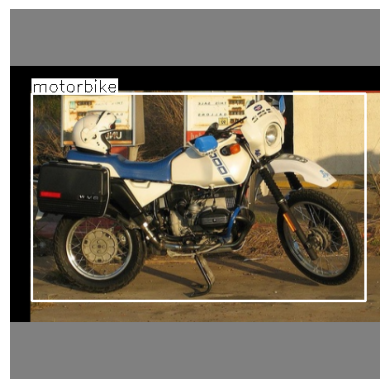

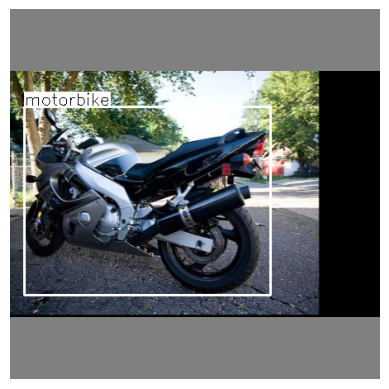

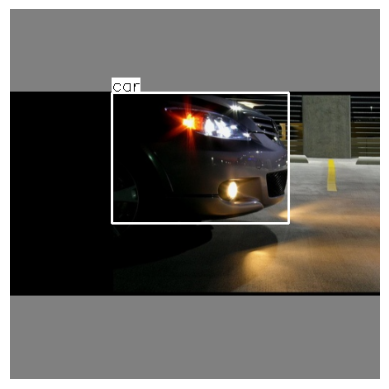

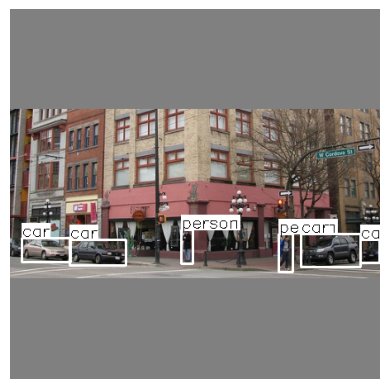

In [ ]:
from train import Trainer

dummy_dataset = data.VocDataset(anno_file_type="train", img_size=cfg.TRAIN["TRAIN_IMG_SIZE"], vis=True)
dataloader = DataLoader(dummy_dataset, shuffle=True, batch_size=1, num_workers=0)

for i, (img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes) in enumerate(dataloader):
    if i<4:
        if (img.shape[0]==1):
            labels = np.concatenate([label_sbbox.reshape(-1, 16), label_mbbox.reshape(-1, 16),
                                     label_lbbox.reshape(-1, 16)], axis=0)
            labels_mask = labels[..., 4]>0
            labels = np.concatenate([labels[labels_mask][..., :4], np.argmax(labels[labels_mask][..., 6:],
                                    axis=-1).reshape(-1, 1)], axis=-1)
            tools.plot_box(labels, img, id=1)
    else:
        break

# YoloV3 Architecture

Comprises of primarily 3 modules:
- Darknet53 backbone
- Feature Pyramid Network (FPN)
- Yolo heads (classification and regression)

Refer to original paper (https://pjreddie.com/media/files/papers/YOLOv3.pdf) for more details

We have already provided the backbone and FPN's architecture in the code. You need to complete
- Writing Yolo heads
- initializing both FPN and Yolo heads with correct parameters
- Completing the YoloV3 forward pass.

## Feature Pyramid Network (FPN)

## Yolo Heads

Here, you'll implement the logic for converting FPN predictions -> box coordinates ```(dx,dy,dw,dh)```, box confidence and class probablities (both in range ```[-1,1]```) into     final box coordinates ```(x,y,w,h)```, box confidence and class probabilities (both in range ```[0,1]```)

Head over to **TODO** for `forward` function of `Yolo_head` class. Once you complete that, run the following to check your implementation

**Note:** The autograder will have more comprehensive test case where it will check the predicted values from `Yolo_head` (and not just the range).

**GradeScope Submission:**
- Upload `yolo_head.py` to gradescope

In [ ]:
from model.head.yolo_head import Yolo_head

##### Test Output Shapes #####
nC = 20 # For example, let's assume we have 20 classes
anchors = torch.Tensor([[10,13], [16,30], [33,23]]) # Sample anchors
stride = 32
batch_size = 8
grid_size = 13 # Grid size

# Instantiate Yolo_head object
yolo_head = Yolo_head(nC, anchors, stride)

# Simulate the input tensor
p = torch.randn(batch_size, 3 * (5 + nC), grid_size, grid_size)

# Call the forward method
p, p_d = yolo_head(p)

# Check shape of the outputs
assert p.shape == (batch_size, grid_size, grid_size, 3, 5 + nC)
assert p_d.shape == (batch_size, grid_size, grid_size, 3, 5 + nC)
print('Test Case 1 Passed!')



##### Test Output range values #####
nC = 20
anchors = torch.Tensor([[10,13], [16,30], [33,23]])
stride = 32
batch_size = 8
grid_size = 13

yolo_head = Yolo_head(nC, anchors, stride)

p = torch.randn(batch_size, 3 * (5 + nC), grid_size, grid_size)
_, p_d = yolo_head(p)

# Extract components from the decoded tensor
xy = p_d[..., 0:2]
wh = p_d[..., 2:4]
conf = p_d[..., 4:5]
prob = p_d[..., 5:]

# Check xy range
assert (xy >= 0).all() and (xy <= grid_size * stride).all(), "xy values are out of valid range!"
# Check wh positivity
assert (wh > 0).all(), "w,h values should be positive!"
# Check confidence score range
assert (conf >= 0).all() and (conf <= 1).all(), "Confidence scores are out of [0,1] range!"
# Check class probabilities range
assert (prob >= 0).all() and (prob <= 1).all(), "Class probabilities are out of [0,1] range!"
print('Test Case 2 Passed!')

Test Case 1 Passed!
Test Case 2 Passed!


## YoloV3 Forward Pass
Now, as all 3 modules are there, head over to **TODO** section of `yolov3.py`. Once you complete that, run the following to check your implementation.

**GradeScope Submission:**
- Change the following import
`
from model.head.yolo_head import Yolo_head
`
to
`
from student_submission import Yolo_head
`
before submission.
- Upload `yolov3.py` to gradescope

In [ ]:
from model.yolov3 import Yolov3

## Testing FPN output shapes
model = Yolov3(cfg)
batch_size = 1
channels = 3
input_size = 448
num_classes = 10
anchors = torch.Tensor([[10,13], [16,30], [33,23]])
num_anchors_per_scale = anchors.shape[0]
input_img = torch.randn(batch_size, channels, input_size, input_size)

x_s, x_m, x_l = model._Yolov3__backnone(input_img)

x_s, x_m, x_l = model._Yolov3__fpn(x_l, x_m, x_s)
C = num_anchors_per_scale*(num_classes + 5)
assert x_s.shape == (batch_size, C, 56, 56), "FPN output x_s shape {} does not match with expected shape {}".format(x_s.shape, (batch_size, C, 56, 56))
assert x_m.shape == (batch_size, C, 28, 28), "FPN output x_m shape {} does not match with expected shape {}".format(x_m.shape, (batch_size, C, 28, 28))
assert x_l.shape == (batch_size, C, 14, 14), "FPN output x_l shape {} does not match with expected shape {}".format(x_l.shape, (batch_size, C, 14, 14))
print('FPN output shapes test passed!!')

## Testing YoloV3 forward pass shape
channels = 3
input_size = 448
num_classes = 10
anchors = torch.Tensor([[10,13], [16,30], [33,23]])
num_anchors_per_scale = anchors.shape[0]
input_img = torch.randn(batch_size, channels, input_size, input_size)

yolov3_output = model(input_img)

C = num_anchors_per_scale*(num_classes + 5)

assert type(yolov3_output) is tuple, "YoloV3 forward output should be tuple containing p and p_d. Go through the docstring for more details"
assert len(yolov3_output) == 2, "YoloV3 output should be a tuple of length 2. But got {} length instead".format(len(yolov3_output))
p, p_d = yolov3_output
assert p[0].shape == (batch_size, 56, 56, channels, num_classes+5), "p[0] shape {} does not match with expected shape {}".format(p[0].shape, (batch_size, 56, 56, channels, num_classes+5))
assert p[1].shape == (batch_size, 28, 28, channels, num_classes+5), "p[1] shape {} does not match with expected shape {}".format(p[1].shape, (batch_size, 28, 28, channels, num_classes+5))
assert p[2].shape == (batch_size, 14, 14, channels, num_classes+5), "p[2] shape {} does not match with expected shape {}".format(p[2].shape, (batch_size, 14, 14, channels, num_classes+5))
assert p_d[0].shape == (batch_size, 56, 56, channels, num_classes+5), "p_d[0] shape {} does not match with expected shape {}".format(p_d[0].shape, (batch_size, 56, 56, channels, num_classes+5))
assert p_d[1].shape == (batch_size, 28, 28, channels, num_classes+5), "p_d[1] shape {} does not match with expected shape {}".format(p_d[1].shape, (batch_size, 28, 28, channels, num_classes+5))
assert p_d[2].shape == (batch_size, 14, 14, channels, num_classes+5), "p_d[2] shape {} does not match with expected shape {}".format(p_d[2].shape, (batch_size, 14, 14, channels, num_classes+5))
print('YoloV3 Forward pass output shapes test passed!!')

initing Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## YoloV3 loss optimization

Now, the forward pass of YoloV3 is completed. YoloV3 is trained using classification, regression and confidence losses. Confidence loss is already provided.

Head over to `TODO` section of `yolo_loss.py`, and complete the regression and confidence losses. Once you complete that, run the following to check your implementation.

**NOTE**: The below cell only checks type and output range of loss. Please check the correctness of your implementation in gradescope

**GradeScope Submission:**
- Upload `yolo_loss.py` to gradescope.

In [ ]:
from model.loss.yolo_loss import YoloV3Loss
from model.yolov3 import Yolov3

yolov3 = Yolov3(cfg)
loss_fn = YoloV3Loss(cfg.MODEL["ANCHORS"], cfg.MODEL["STRIDES"])

p, p_d = yolov3(torch.rand(1, 3, 448, 448))
label_sbbox = torch.rand(1, 56, 56, 3, 16)
label_mbbox = torch.rand(1, 28, 28, 3, 16)
label_lbbox = torch.rand(1, 14, 14, 3, 16)
sbboxes = torch.rand(1, 150, 4)
mbboxes = torch.rand(1, 150, 4)
lbboxes = torch.rand(1, 150, 4)

loss, loss_giou, loss_conf, loss_cls = loss_fn(p, p_d, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes)

assert isinstance(loss, torch.Tensor), "loss Tensor of type {}, should be torch.Tensor instead".format(type(loss))
assert isinstance(loss_giou, torch.Tensor), "loss_giou Tensor of type {}, should be torch.Tensor instead".format(type(loss_giou))
assert isinstance(loss_conf, torch.Tensor), "loss_conf Tensor of type {}, should be torch.Tensor instead".format(type(loss_conf))
assert isinstance(loss_cls, torch.Tensor), "loss_cls Tensor of type {}, should be torch.Tensor instead".format(type(loss_cls))

assert loss>=0, "loss Tensor should be >=0"
assert loss_giou>=0, "loss_giou Tensor should be >=0"
assert loss_conf>=0, "loss_conf Tensor should be >=0"
assert loss_cls>=0, "loss_cls Tensor should be >=0"
print('Loss type and range value test - Passed')

initing Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Post-processing: Non-maxima Suppression

Outputs from object detectors generally tend to have multiple redundant predictions per object. Hence, we'll implement an algorithm - Non-maxima suppression to suppress the redundant predictions and only keep the most confident one having highest IoU with other corresponding predictions.

Head over to `TODO` section of `tools.py` and complete `nms()`. Once you complete that, run the following to check your implementation.

**Gradescope Submission:**
- Upload `utils\tools.py` file to gradescope.

In [ ]:
from utils.tools import nms

## Test NMS Basic Functionality
bboxes = np.array([[10, 10, 50, 50, 0.9, 1], [15, 15, 55, 55, 0.8, 1]])
gt_bboxes = np.array([[10., 10., 50., 50., 0.9, 1.]])
score_threshold = 0.7
iou_threshold = 0.5
output_bboxes = nms(bboxes, score_threshold, iou_threshold)
assert np.allclose(np.sort(output_bboxes.copy().flatten()), np.sort(gt_bboxes.copy().flatten())), "Output boxes {}  and ground truth boxes {} do not match ".format(output_bboxes, gt_bboxes)
print('NMS Basic Functionality Test - Passed')

## Bounding box of multiple classes overlap
bboxes= np.array([[10, 10, 50, 50, 0.9, 1], [15, 15, 55, 55, 0.8, 1], [100, 100, 150, 150, 0.95, 2], [105, 105, 155, 155, 0.85, 2]])
score_threshold = 0.7
iou_threshold = 0.5
gt_bboxes = np.array([[10, 10, 50, 50, 0.9, 1], [100, 100, 150, 150, 0.95, 2]])
output_bboxes = nms(bboxes, score_threshold, iou_threshold)
assert gt_bboxes.shape[0] == output_bboxes.shape[0], "No. of GT boxes {} and output boxes {} are not equal".format(gt_bboxes.shape[0], output_bboxes.shape[0])
assert np.allclose(np.sort(output_bboxes.copy().flatten()), np.sort(gt_bboxes.copy().flatten())), "Output boxes {}  and ground truth boxes {} do not match ".format(output_bboxes, gt_bboxes)
print('NMS - Multiple class bounding box overlap - Passed')

NMS Basic Functionality Test - Passed
NMS - Multiple class bounding box overlap - Passed


## Training YoloV3
Now, train the YoloV3 architecture end-to-end using the above Yolo losses, and report the **final mAP**.

**Note:** The best model gets saved with name `best.pt` under the directory `weight`.

### Creating a Results Dir

In [ ]:
if (not os.path.exists('results/voc')):
    os.mkdir(os.path.join(YOLO_HOME, 'results'))
    os.mkdir(os.path.join(YOLO_HOME, 'results/voc'))

    for label in cfg.DATA['CLASSES']:
        filename = 'comp4_det_test_'+label+'.txt'
        os.system('touch results/voc/'+filename)

In [ ]:
Trainer(weight_path='weight/darknet53_448.weights',
            resume=False,
            gpu_id=0).train()

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15101MB)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


initing Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

100%|██████████| 23/23 [00:01<00:00, 22.66it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 1 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5e-05
Epoch:[ 1 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.5625e-05
Epoch:[ 1 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.125e-05
Epoch:[ 1 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.6875e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 16.82it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 2 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 0.0001
Epoch:[ 2 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.99549e-05
Epoch:[ 2 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.98197e-05
Epoch:[ 2 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.95947e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 12.34it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 3 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.9539e-05
Epoch:[ 3 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.92067e-05
Epoch:[ 3 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.87857e-05
Epoch:[ 3 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.82767e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 18.91it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 4 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.81644e-05
Epoch:[ 4 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.75511e-05
Epoch:[ 4 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.68521e-05
Epoch:[ 4 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.60687e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 14.23it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 5 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.5902e-05
Epoch:[ 5 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.50191e-05
Epoch:[ 5 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.40551e-05
Epoch:[ 5 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.30118e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 22.96it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 6 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.27938e-05
Epoch:[ 6 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.16577e-05
Epoch:[ 6 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.04468e-05
Epoch:[ 6 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.9163e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 20.32it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 7 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.88977e-05
Epoch:[ 7 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.75297e-05
Epoch:[ 7 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.60943e-05
Epoch:[ 7 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.4594e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 14.57it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 8 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.42864e-05
Epoch:[ 8 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.27119e-05
Epoch:[ 8 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.10787e-05
Epoch:[ 8 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.93899e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 21.47it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 9 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.90457e-05
Epoch:[ 9 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.7294e-05
Epoch:[ 9 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.54936e-05
Epoch:[ 9 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.36476e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 18.09it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 10 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.32732e-05
Epoch:[ 10 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.1377e-05
Epoch:[ 10 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.94428e-05
Epoch:[ 10 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.74741e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 13.81it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 11 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.70765e-05
Epoch:[ 11 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.50712e-05
Epoch:[ 11 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.30392e-05
Epoch:[ 11 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.09844e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 21.10it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 12 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.05711e-05
Epoch:[ 12 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.84938e-05
Epoch:[ 12 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.6402e-05
Epoch:[ 12 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.42995e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 13.03it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 13 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.3878e-05
Epoch:[ 13 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.17676e-05
Epoch:[ 13 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.96549e-05
Epoch:[ 13 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.75437e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 14.76it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 14 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.7122e-05
Epoch:[ 14 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.50178e-05
Epoch:[ 14 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.29235e-05
Epoch:[ 14 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.0843e-05
********************Validate********************


100%|██████████| 23/23 [00:00<00:00, 25.83it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 15 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.04289e-05
Epoch:[ 15 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.837e-05
Epoch:[ 15 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.63332e-05
Epoch:[ 15 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.43222e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 21.90it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 16 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.39235e-05
Epoch:[ 16 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.19483e-05
Epoch:[ 16 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.00069e-05
Epoch:[ 16 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.81028e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 21.58it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 17 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.77268e-05
Epoch:[ 17 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.58721e-05
Epoch:[ 17 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.40623e-05
Epoch:[ 17 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.23006e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 15.49it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 18 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.19543e-05
Epoch:[ 18 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.02547e-05
Epoch:[ 18 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.86101e-05
Epoch:[ 18 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.70237e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 14.10it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 19 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.67136e-05
Epoch:[ 19 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.52007e-05
Epoch:[ 19 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.37521e-05
Epoch:[ 19 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.23704e-05
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 22.30it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 20 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.21023e-05
Epoch:[ 20 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.08043e-05
Epoch:[ 20 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 9.57852e-06
Epoch:[ 20 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.42734e-06
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 13.68it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 21 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 8.20624e-06
Epoch:[ 21 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 7.14727e-06
Epoch:[ 21 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 6.16728e-06
Epoch:[ 21 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.26805e-06
********************Validate********************


100%|██████████| 23/23 [00:00<00:00, 26.71it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 22 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 5.09804e-06
Epoch:[ 22 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 4.29787e-06
Epoch:[ 22 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 3.58187e-06
Epoch:[ 22 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.95134e-06
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 20.39it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 23 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.83559e-06
Epoch:[ 23 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 2.30913e-06
Epoch:[ 23 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.87046e-06
Epoch:[ 23 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.52037e-06
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 19.15it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
Epoch:[ 24 | 24 ]    Batch:[ 0 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.46105e-06
Epoch:[ 24 | 24 ]    Batch:[ 5 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.21809e-06
Epoch:[ 24 | 24 ]    Batch:[ 10 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.06492e-06
Epoch:[ 24 | 24 ]    Batch:[ 15 | 15 ]    loss_giou: nan    loss_conf: nan    loss_cls: nan    loss: nan    lr: 1.0018e-06
********************Validate********************


100%|██████████| 23/23 [00:01<00:00, 12.63it/s]


Reading annotation for 1/23
Saving cached annotations to /content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 3/results/voc/cache/annots.pkl
bicycle --> mAP : 0
boat --> mAP : 0
bottle --> mAP : 0
bus --> mAP : 0
car --> mAP : 0
cat --> mAP : 0
chair --> mAP : 0
dog --> mAP : 0
motorbike --> mAP : 0
person --> mAP : 0
mAP:0
best mAP : 0
